# Inhaltsverzeichnis

| Abschnitt | Unterabschnitt |
|-----------|----------------|
| **[Zusammenfassung des LSTM-Modells für Zeitreihenvorhersagen](#zusammenfassung-des-lstm-modells-für-zeitreihenvorhersagen)** | |
| **[LSTM Modell mit Lag und Umweltvariablen](#lstm-modell-mit-lag-und-umwelt-variablen)** | |
| **[Zusammenfassung](#zusammenfassung)** | |
| **[Extrahiere Residuen aus dem LSTM-Modell](#extrahiere-residuen-aus-dem-lstm-modell)** | |
| **[Residuen-Visualisierung](#residuen-visualisierung)** | |
| **[Residuen-Stationaritätsstatistiken-Tests](#residuen-stationaritätsstatistiken-tests)** | |
| **[Cross Validation](#cross-validation)** | |


### Zusammenfassung des LSTM-Modells für Zeitreihenvorhersagen

**Überblick:**
Dieses Modell nutzt eine Long Short-Term Memory (LSTM) Architektur, die speziell für die Analyse und Vorhersage von Zeitreihendaten konzipiert ist, bei denen zeitliche Abhängigkeiten entscheidend sind.

**Schichten:**
- **LSTM-Schicht:**
  - **Einheiten:** 50
  - **Ausgabeform:** `(None, 50)` (variable Batchgröße, gibt 50 Merkmale pro Probe aus)
  - **Parameter:** 10,400
  - **Erklärung:** Die LSTM-Schicht ist darauf ausgelegt, Eingangssequenzen zu verarbeiten, indem sie wichtige zeitliche Informationen über interne Strukturen wie Eingangs-, Vergessens-, und Ausgangstore aufrechterhält und speichert.

- **Dichteschicht:**
  - **Einheiten:** 1
  - **Ausgabeform:** `(None, 1)` (gibt einen einzigen Wert pro Probe aus)
  - **Parameter:** 51 (50 Gewichte + 1 Bias)
  - **Erklärung:** Diese Schicht wandelt die komplexen Merkmale, die von der LSTM-Schicht verarbeitet wurden, in eine finale Vorhersage um.

**Gesamtanzahl der Parameter:**
- **Trainierbare Parameter:** 10,451
- **Erklärung:** Die hohe Anzahl an anpassbaren Parametern spiegelt die Fähigkeit des Modells wider, aus den Daten zu lernen und sich an die gegebenen Muster anzupassen.

Das Modell ist ideal geeignet, um langfristige Muster und Abhängigkeiten in Zeitreihendaten zu erkennen und effektiv für Vorhersagen zu nutzen.


## LSTM Modell mit Lag und Umwelt Variablen

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import json

# Load the dataset
file_path = './Data_Waldbrand_Zeitreihen/daily_data_merged/merged_with_daily_fire_counts.csv'
data = pd.read_csv(file_path)

# Convert dates to datetime objects and extract useful features
data['DISCOVERY_DATE'] = pd.to_datetime(data['DISCOVERY_DATE'])
data['CONT_DATE'] = pd.to_datetime(data['CONT_DATE'])
data['FIRE_DURATION'] = (data['CONT_DATE'] - data['DISCOVERY_DATE']).dt.days

# Add logarithm of fire counts
data['LOG_FIRE_COUNTS'] = np.log1p(data['Daily Fire Counts'])  # log1p to handle zero values safely

# Add lag features
n_lag = 20  # Number of lag days
for i in range(1, n_lag + 1):
    data[f'lag_{i}'] = data['LOG_FIRE_COUNTS'].shift(i)

# Drop rows with NaN values caused by lags
data.dropna(inplace=True)

# Select features and target
features = ['Precipitation', 'Inferred_Wind_Speed', 'MaxTemperature', 'MinTemperature','LATITUDE','LONGITUDE'] + \
           [f'lag_{i}' for i in range(1, n_lag + 1)]
target = 'LOG_FIRE_COUNTS'

# Prepare the data
X = data[features].values
y = data[target].values

# Normalize the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape features for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(80, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='log_cosh')

# Early Stopping and Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('./Data_Waldbrand_Zeitreihen/Model_Results/best_model_with_lags.keras',
                                   save_best_only=True, monitor='val_loss', mode='max')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint])

# Save the final trained model
#model.save('./Data_Waldbrand_Zeitreihen/Model_Results/lstm_model_with_external_vars_final.keras')

# Save training history
history_dict = history.history
with open('./Data_Waldbrand_Zeitreihen/Model_Results/training_history_with_lags.json', 'w') as file:
    json.dump(history_dict, file)

print("Training complete. Model and history saved.")


Epoch 1/50
16891/16891 ━━━━━━━━━━━━━━━━━━━━ 242s 14ms/step - loss: 0.1239 - val_loss: 0.0699
Epoch 2/50
16891/16891 ━━━━━━━━━━━━━━━━━━━━ 229s 14ms/step - loss: 0.0697 - val_loss: 0.0662
Epoch 3/50
16891/16891 ━━━━━━━━━━━━━━━━━━━━ 227s 13ms/step - loss: 0.0671 - val_loss: 0.0639
Epoch 4/50
16891/16891 ━━━━━━━━━━━━━━━━━━━━ 225s 13ms/step - loss: 0.0658 - val_loss: 0.0651
Epoch 5/50
16891/16891 ━━━━━━━━━━━━━━━━━━━━ 232s 14ms/step - loss: 0.0643 - val_loss: 0.0644
Epoch 6/50
16891/16891 ━━━━━━━━━━━━━━━━━━━━ 235s 14ms/step - loss: 0.0637 - val_loss: 0.0623
Epoch 7/50
16891/16891 ━━━━━━━━━━━━━━━━━━━━ 239s 14ms/step - loss: 0.0629 - val_loss: 0.0617
Epoch 8/50
16891/16891 ━━━━━━━━━━━━━━━━━━━━ 232s 14ms/step - loss: 0.0623 - val_loss: 0.0639
Epoch 9/50
16891/16891 ━━━━━━━━━━━━━━━━━━━━ 232s 14ms/step - loss: 0.0624 - val_loss: 0.0608
Epoch 10/50
16891/16891 ━━━━━━━━━━━━━━━━━━━━ 234s 14ms/step - loss: 0.0634 - val_loss: 0.0630
Epoch 11/50
16891/16891 ━━━━━━━━━━━━━━━━━━━━ 232s 14ms/step - loss: 0

## Zusammenfassung

In [1]:
from tensorflow.keras.models import load_model
import numpy as np

# Load the trained LSTM model
model_file_path = './Data_Waldbrand_Zeitreihen/Model_Results/best_model_with_lags.keras'
model = load_model(model_file_path)

# Print the model summary
print("Model Summary:")
model.summary()

# Retrieve weights for all layers
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    print(f"\nLayer {i+1} ({layer.name}):")
    if len(weights) > 0:
        for w_i, w in enumerate(weights):
            print(f"  Weight {w_i+1}: Shape {np.shape(w)}")
    else:
        print("  No weights for this layer.")


Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 26, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 80)             │        57,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         4,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,465 (1.18 MB)

 Trainable params: 102,821 (401.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 205,644 (803.30 KB)


Layer 1 (lstm_4):
  Weight 1: Shape (1, 400)
  Weight 2: Shape (100, 400)
  Weight 3: Shape (400,)

Layer 2 (lstm_5):
  Weight 1: Shape (100, 320)
  Weight 2: Shape (80, 320)
  Weight 3: Shape (320,)

Layer 3 (dense_4):
  Weight 1: Shape (80, 50)
  Weight 2: Shape (50,)

Layer 4 (dense_5):
  Weight 1: Shape (50, 1)
  Weight 2: Shape (1,)


# Extrahiere Residuen aus dem LSTM-Modell


21114/21114 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step
Residuals saved at: ./Data_Waldbrand_Zeitreihen/daily_data_merged/lstm_model_residuals.csv


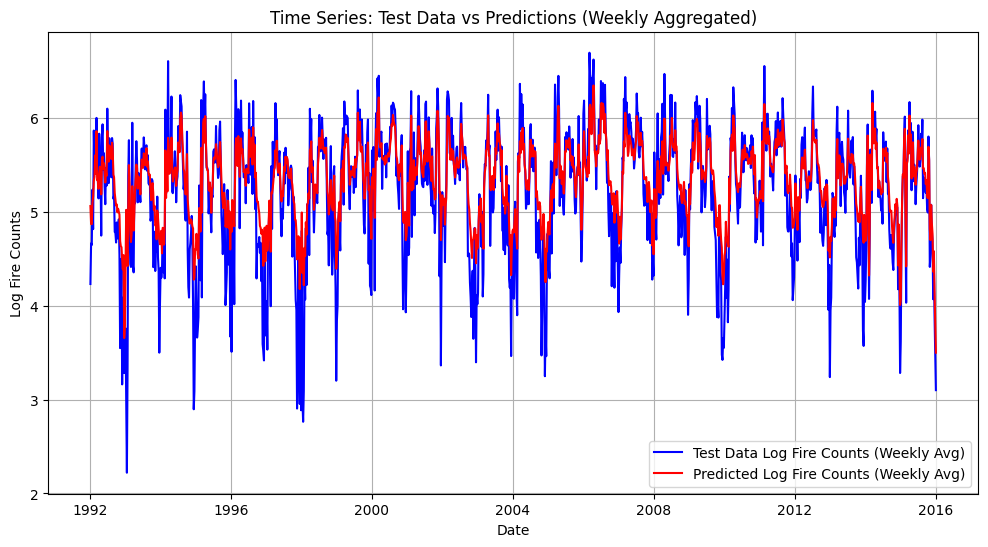

Test vs Predictions plot (aggregated) saved at: ./Abbildungen/lstm_test_vs_predictions_aggregated.png


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import os

# Load the dataset
file_path = './Data_Waldbrand_Zeitreihen/daily_data_merged/merged_with_daily_fire_counts.csv'
data = pd.read_csv(file_path)

# Convert dates to datetime objects and extract useful features
data['DISCOVERY_DATE'] = pd.to_datetime(data['DISCOVERY_DATE'])
data['CONT_DATE'] = pd.to_datetime(data['CONT_DATE'])
data['FIRE_DURATION'] = (data['CONT_DATE'] - data['DISCOVERY_DATE']).dt.days

# Add logarithm of fire counts
data['LOG_FIRE_COUNTS'] = np.log1p(data['Daily Fire Counts'])  # log1p to handle zero values safely

# Add lag features
n_lag = 20  # Number of lag days
for i in range(1, n_lag + 1):
    data[f'lag_{i}'] = data['LOG_FIRE_COUNTS'].shift(i)

# Drop rows with NaN values caused by lags
data.dropna(inplace=True)

# Select features and target
features = ['Precipitation', 'Inferred_Wind_Speed', 'MaxTemperature', 'MinTemperature', 'LATITUDE', 'LONGITUDE'] + \
           [f'lag_{i}' for i in range(1, n_lag + 1)]
target = 'LOG_FIRE_COUNTS'

# Prepare the data
X = data[features].values
y = data[target].values

# Normalize the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape features for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

# Load the model
model_path = './Data_Waldbrand_Zeitreihen/Model_Results/lstm_model_with_external_vars_final.keras'
model = load_model(model_path)

# Generate predictions
predicted_log_fire_counts = model.predict(X)

# Calculate residuals
residuals = y - predicted_log_fire_counts.flatten()

# Create a DataFrame for residuals with date
residuals_df = pd.DataFrame({
    "Date": data['DISCOVERY_DATE'],
    "Residuals": residuals
})

# Save residuals to a CSV file
residuals_output_path = './Data_Waldbrand_Zeitreihen/daily_data_merged/lstm_model_residuals.csv'
os.makedirs(os.path.dirname(residuals_output_path), exist_ok=True)
residuals_df.to_csv(residuals_output_path, index=False)
print(f"Residuals saved at: {residuals_output_path}")

# Create a DataFrame for actual and predicted values
df = pd.DataFrame({
    "Date": data['DISCOVERY_DATE'],
    "Actual": y,
    "Predicted": predicted_log_fire_counts.flatten()
})

# Aggregate points for better visualization (weekly mean)
df.set_index('Date', inplace=True)
df_weekly = df.resample('W').mean()

# Plot the aggregated test set with predicted values
plt.figure(figsize=(12, 6))
plt.plot(df_weekly.index, df_weekly['Actual'], label="Test Data Log Fire Counts (Weekly Avg)", color="blue", linestyle="-")
plt.plot(df_weekly.index, df_weekly['Predicted'], label="Predicted Log Fire Counts (Weekly Avg)", color="red", linestyle="-")
plt.title("Time Series: Test Data vs Predictions (Weekly Aggregated)")
plt.xlabel("Date")
plt.ylabel("Log Fire Counts")
plt.legend()
plt.grid(True)

# Save the plot
plot_output_path = './Abbildungen/lstm_test_vs_predictions_aggregated.png'
os.makedirs(os.path.dirname(plot_output_path), exist_ok=True)
plt.savefig(plot_output_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Test vs Predictions plot (aggregated) saved at: {plot_output_path}")


# Residuen-Visualisierung


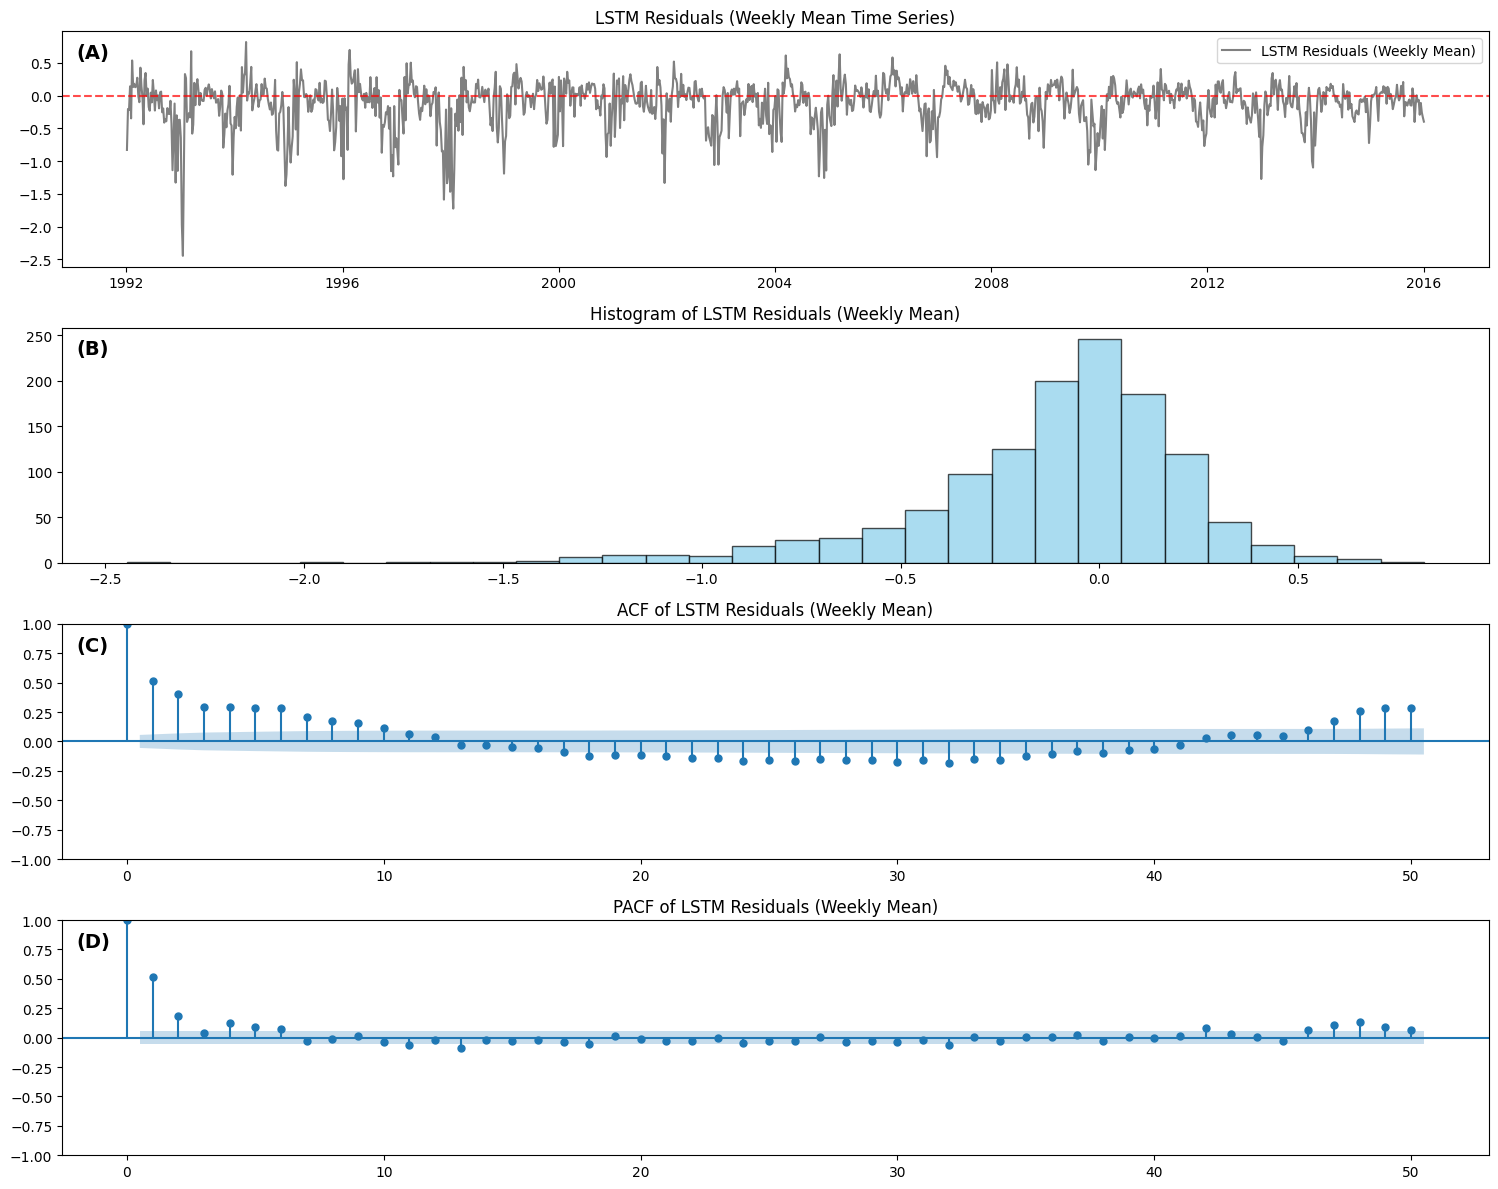

LSTM residual analysis plot saved at: ./Abbildungen\lstm_residual_analysis_weekly.png


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os

# Load the residuals data from the LSTM model
residuals_file_path = './Data_Waldbrand_Zeitreihen/daily_data_merged/lstm_model_residuals.csv'
residuals_df = pd.read_csv(residuals_file_path, parse_dates=['Date'])

# Ensure the 'Residuals' column exists
if 'Residuals' not in residuals_df.columns:
    raise ValueError("The file does not contain a 'Residuals' column.")

residuals = residuals_df['Residuals']

# Aggregate residuals to weekly means for better visualization
weekly_residuals = residuals_df.resample('W', on='Date')['Residuals'].mean()

# Residual Analysis for LSTM Model
plt.figure(figsize=(15, 12))

# Residual time series
plt.subplot(411)
plt.plot(weekly_residuals.index, weekly_residuals, label='LSTM Residuals (Weekly Mean)', color='gray')
plt.axhline(0, linestyle='--', color='red', alpha=0.7)
plt.text(0.01, 0.95, '(A)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
plt.title('LSTM Residuals (Weekly Mean Time Series)')
plt.legend()

# Histogram of residuals
plt.subplot(412)
plt.hist(weekly_residuals.dropna().values, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.text(0.01, 0.95, '(B)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
plt.title('Histogram of LSTM Residuals (Weekly Mean)')

# ACF plot of residuals
plt.subplot(413)
plot_acf(weekly_residuals.dropna(), lags=50, ax=plt.gca(), title='ACF of LSTM Residuals (Weekly Mean)', alpha=0.05)
plt.text(0.01, 0.95, '(C)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# PACF plot of residuals
plt.subplot(414)
plot_pacf(weekly_residuals.dropna(), lags=50, ax=plt.gca(), title='PACF of LSTM Residuals (Weekly Mean)', alpha=0.05)
plt.text(0.01, 0.95, '(D)', transform=plt.gca().transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Save the plot to the 'Abbildungen' folder
output_dir = './Abbildungen'
os.makedirs(output_dir, exist_ok=True)
lstm_residuals_output_path = os.path.join(output_dir, 'lstm_residual_analysis_weekly.png')
plt.tight_layout()
plt.savefig(lstm_residuals_output_path, dpi=300)
plt.show()

print(f"LSTM residual analysis plot saved at: {lstm_residuals_output_path}")


## Residuen-Stationaritätsstatistiken-Tests


In [9]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import kpss, adfuller

# Suppress warnings in the output
import warnings
warnings.filterwarnings("ignore")

# Load the residuals data from the previously created CSV file
daily_residuals_output_csv_path = "./Data_Waldbrand_Zeitreihen/daily_data_merged/lstm_model_residuals.csv"

# Ensure the file exists and handle errors
try:
    arima_residuals = pd.read_csv(daily_residuals_output_csv_path, parse_dates=True)
    if 'Residuals' not in arima_residuals.columns:
        raise ValueError("The file does not contain a 'Residuals' column.")
except FileNotFoundError:
    raise FileNotFoundError(f"The file {daily_residuals_output_csv_path} does not exist.")
except ValueError as e:
    raise ValueError(e)

# Extract the residuals
residuals = arima_residuals['Residuals']

# Reduce the size of the residuals by slicing or downsampling
residuals_reduced = residuals.iloc[::600].dropna()  # Keep every 10th point

# Perform the Augmented Dickey-Fuller test on the reduced residuals
adf_test = adfuller(residuals_reduced)

# Output the results for ADF test
print('ADF Statistic (Reduced Residuals): %f' % adf_test[0])
print('p-value (Reduced Residuals): %f' % adf_test[1])
print('Critical Values (Reduced Residuals):')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

# Determine stationarity based on ADF test
if adf_test[1] < 0.05:
    print("The reduced residuals are stationary according to the ADF test.")
else:
    print("The reduced residuals are not stationary according to the ADF test.")

# Perform the KPSS test on the reduced residuals
kpss_test = kpss(residuals_reduced, regression='c')  # 'c' for constant in the regression

# Output the results for KPSS test
print('KPSS Statistic (Reduced Residuals): %f' % kpss_test[0])
print('p-value (Reduced Residuals): %f' % kpss_test[1])
print('Critical Values (Reduced Residuals):')
for key, value in kpss_test[3].items():
    print('\t%s: %.3f' % (key, value))

# Determine stationarity based on KPSS test
if kpss_test[1] < 0.05:
    print("The reduced residuals are not stationary according to the KPSS test.")
else:
    print("The reduced residuals are stationary according to the KPSS test.")


ADF Statistic (Reduced Residuals): -33.021525
p-value (Reduced Residuals): 0.000000
Critical Values (Reduced Residuals):
	1%: -3.436
	5%: -2.864
	10%: -2.568
The reduced residuals are stationary according to the ADF test.
KPSS Statistic (Reduced Residuals): 0.114228
p-value (Reduced Residuals): 0.100000
Critical Values (Reduced Residuals):
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
The reduced residuals are stationary according to the KPSS test.


## Cross Validation


In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import os

# Load the dataset
file_path = './Data_Waldbrand_Zeitreihen/daily_data_merged/merged_with_daily_fire_counts.csv'
data = pd.read_csv(file_path)

# Convert dates to datetime objects and extract useful features
data['DISCOVERY_DATE'] = pd.to_datetime(data['DISCOVERY_DATE'])
data['CONT_DATE'] = pd.to_datetime(data['CONT_DATE'])
data['FIRE_DURATION'] = (data['CONT_DATE'] - data['DISCOVERY_DATE']).dt.days

# Add logarithm of fire counts
data['LOG_FIRE_COUNTS'] = np.log1p(data['Daily Fire Counts'])  # log1p to handle zero values safely

# Add lag features
n_lag = 20  # Number of lag days
for i in range(1, n_lag + 1):
    data[f'lag_{i}'] = data['LOG_FIRE_COUNTS'].shift(i)

# Drop rows with NaN values caused by lags
data.dropna(inplace=True)

# Select features and target
features = ['Precipitation', 'Inferred_Wind_Speed', 'MaxTemperature', 'MinTemperature', 'LATITUDE', 'LONGITUDE'] + \
           [f'lag_{i}' for i in range(1, n_lag + 1)]
target = 'LOG_FIRE_COUNTS'

# Prepare the data
X = data[features].values
y = data[target].values

# Normalize the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape features for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

# Load the model
model_path = './Data_Waldbrand_Zeitreihen/Model_Results/lstm_model_with_external_vars_final.keras'
model = load_model(model_path)

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores, mae_scores, rmse_scores = [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Predict using the model
    predictions = model.predict(X_test)

    # Calculate different error metrics
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)

    # Store the scores for final averaging
    mse_scores.append(round(mse, 4))
    mae_scores.append(round(mae, 4))
    rmse_scores.append(round(rmse, 4))

# Average scores across all folds
average_scores = {
    'Metric': ['MSE', 'MAE', 'RMSE'],
    'Average Value': [
        round(np.mean(mse_scores), 4),
        round(np.mean(mae_scores), 4),
        round(np.mean(rmse_scores), 4)
    ]
}

# Create a DataFrame for the averaged values
averaged_scores_df = pd.DataFrame(average_scores)

# Define the path to save the table as an image
output_dir = "./Abbildungen"
os.makedirs(output_dir, exist_ok=True)
output_image_path = os.path.join(output_dir, "NNR_daily_cross_validation_scores.png")

# Save the table as a LaTeX-like styled image
fig, ax = plt.subplots(figsize=(5, 1.5))  # Reduced figure size to minimize margins
ax.axis('tight')
ax.axis('off')

# Create a better-presented table with LaTeX styling
cell_text = [[f"{val}" for val in row] for row in averaged_scores_df.values]
col_labels = averaged_scores_df.columns
ax.table(cellText=cell_text, colLabels=col_labels, loc='center', cellLoc='center', edges='horizontal')

plt.savefig(output_image_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()

print(f"Cross-validation scores table saved at: {output_image_path}")

# Print average scores
print("Average MSE:", round(np.mean(mse_scores), 4))
print("Average MAE:", round(np.mean(mae_scores), 4))
print("Average RMSE:", round(np.mean(rmse_scores), 4))


C:\Users\fsali\AppData\Local\Temp\ipykernel_34276\329782156.py:12: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


4223/4223 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step
4223/4223 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step
4223/4223 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step
4223/4223 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step
4223/4223 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step
Cross-validation scores table saved at: ./Abbildungen\NNR_daily_cross_validation_scores.png
Average MSE: 0.1324
Average MAE: 0.2451
Average RMSE: 0.3639
